# TN Education Bills

Explore legislation related to education in Tennessee using Natural Language Processing.

Guiding questions:

1. Can we identify frequent topics of legislation for legislators?
2. Can we identify legislator positions on topics of legislation?
3. Given observable information about a bill when it is introduced, can we predict its probability of getting passed?

## 0. Setup

The data comes from [OpenStates](https://openstates.org/), which provides a fairly uniform* set of information related to legislators and legislation from all 50 states + DC and Puerto Rico:

* Legislators
    * Party
    * Chamber (Senate or House)
    * Legislative District
    * Committee Assignments
    * Votes
   

* Bills
    * Title (~ 1 sentence summary)
    * Subjects (e.g.: Education, Health, Crime, etc.)
    * Sponsors
    * Votes
    * Actions (e.g.: Passed on 1st/2nd/3rd Consideration, Assignment to Committee, Amendments, Signed into Law)

Data for the five most recent legislative sessions are available via an API or for [download](https://openstates.org/downloads/) as .csv files. I took (~400) files for all states and combined them in a SQLite database.

In [1]:
import numpy as np
import pandas as pd
import sqlite3
%matplotlib inline

pd.set_option('display.max_colwidth', -1)

conn = sqlite3.connect('/Users/alexanderpoon/Desktop/R/legislateR/data/legislateR.db')

bills = pd.read_sql_query('SELECT * FROM bills WHERE state = "tn" AND type = "bill"', conn)

# Data for 106th legislative duplicates 109th, dropping for now
bills = bills[bills['session'] != '106']

# Remove the 'Amends TCA Title x, Chapter y' from bill titles
bills['title'] = bills['title'].replace(to_replace = ' - Amends.+$', value = '', regex = True)

ed_bills = bills[bills['subjects'].str.contains('Education')].reset_index(drop = True)

## 1. Basic Descriptives

**How many bills do we have?**

In [2]:
bills.shape[0]

17524

Companion bills for a piece of legislation are often introduced in both the House and the Senate, so a raw count of bills is overcounting by about 2x.

**Across how many legislative sessions?**

In [3]:
bills['session'].unique()

array(['107', '108', '109', '110'], dtype=object)

Tennessee legislative sessions run two years. For instance, the 110th General Assembly convenes early 2017 and 2018.

**What is the distribution of their subjects? (a bill can cover multiple subjects)**

In [4]:
subjects = bills['subjects'].str.split("|", expand = True)

subjects_long = pd.concat([subjects[0], subjects[1], subjects[2], subjects[3]])

subjects_long[subjects_long.notnull()].value_counts().plot.bar()

Fortunately for the purposes of this analysis, education is an active area of legislation. Let's get a sampling of education related bills.

In [5]:
ed_bills['title'][0]

'Education - As introduced, requires the commissioner of education to submit annual report as of each December 1, rather than November 1.'

In [6]:
ed_bills['title'][1]

'Education, Higher - As introduced, requires the board of trustees of the University of Tennessee system to submit its report to the governor on the number of students and the workings of the system 10 business days instead of 10 days before the general assembly convenes.'

In [7]:
ed_bills['title'][2]

'Local Education Agencies - As introduced, adds local education agencies to those able to sponsor a charter school.'

**Bill titles start with a more specific topic label. Let's get a sampling of these.**

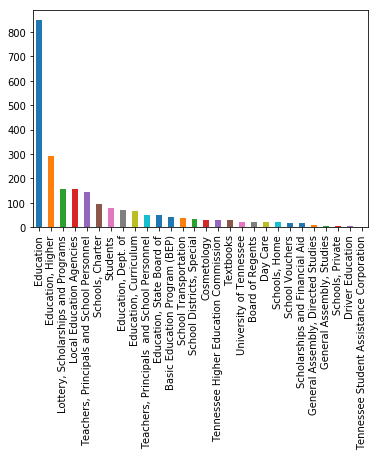

In [8]:
ed_bills['topic'] = ed_bills['title'].str.extract('(^.+? -)', expand = False) \
    .replace('\s-', value = '', regex = True)

ed_bills['topic'].value_counts().plot.bar()

Obviously, not all of these are helpful. We can also search bill titles for some terms of interest.

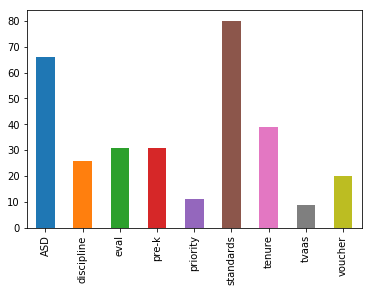

In [9]:
pd.Series({
    'ASD': sum(ed_bills['title'].str.contains('ASD|Achievement School District', case = False)),
    'eval': sum(ed_bills['title'].str.contains('teacher evaluation', case = False)),
    'pre-k': sum(ed_bills['title'].str.contains('pre-k', case = False)),
    'standards': sum(ed_bills['title'].str.contains('standards', case = False)),
    'tvaas': sum(ed_bills['title'].str.contains('TVAAS', case = False)),
    'priority': sum(ed_bills['title'].str.contains('priority school', case = False)),
    'voucher': sum(ed_bills['title'].str.contains('voucher', case = False)),
    'tenure': sum(ed_bills['title'].str.contains('tenure', case = False)),
    'discipline': sum(ed_bills['title'].str.contains('discipline|expulsion|expelled|supension|suspended', case = False))
}).plot.bar()

**Which legislators sponsor the most education related legislation?** 

Each bill lists up to two primary sponsors (usually one House Representative and one Senator).

In [10]:
sponsors_long = pd.read_sql_query('SELECT * FROM bill_sponsors WHERE state = "tn" AND session != "106"', conn)

sponsor1 = sponsors_long[sponsors_long.duplicated(['state', 'session', 'bill_id'], keep = 'first')] \
    .rename(columns = {'name': 'sponsor1'}) \
    .drop(['type', 'leg_id'], axis = 1)
sponsor2 = sponsors_long[sponsors_long.duplicated(['state', 'session', 'bill_id'], keep = 'last')] \
    .rename(columns = {'name': 'sponsor2'}) \
    .drop(['type', 'leg_id'], axis = 1)

sponsors = pd.merge(sponsor1, sponsor2, on = ['state', 'session', 'chamber', 'bill_id'])

In [11]:
ed_bills_with_sponsors = pd.merge(ed_bills, sponsors, on = ['state', 'session', 'chamber', 'bill_id'], how = 'left')

ed_bills_sponsors = pd.concat([ed_bills_with_sponsors['sponsor1'], ed_bills_with_sponsors['sponsor2']])

ed_bills_sponsors[ed_bills_sponsors.notnull()].value_counts().head(25).plot.bar()

**We can also track what happens to bills.**

In Tennessee, in order for a [bill to become law](http://www.capitol.tn.gov/about/billtolaw.html), it must be passed on three separate considerations in each chamber (House and Senate) and signed by the Governor or allowed to become law without the Governor's signature. Roughly, a bill must go through the following process in order to become law:

* Introduced
* Passed on First Consideration
* Passed on Second Consideration
* Referred to Committee(s)
* Placed on Calendar for Third Consideration
    * On Third consderstion, opened for debate and amendment
* Passed on Third Consideration
* Reconcile Senate and House versions
* Signed by Governor or allowed to become law without signature

A bill passed by both chambers can be vetoed by the Governor. The legislature can then [override](http://www.tennessean.com/story/news/politics/2016/04/20/tennessee-general-assembly-bible-veto-override-vote/83263302/) a veto with a simple majority vote.

**Let's see what the trajectory of a bill might look like.**

In [12]:
query_actions = 'SELECT * FROM bill_actions WHERE state = "tn"'

actions = pd.read_sql_query(query_actions, conn)

In [13]:
ed_bills[(ed_bills.session == "107") & (ed_bills.bill_id == "HB 3540")].reset_index(drop = True).title[0]

"Schools, Charter - As enacted, regulates charter schools' relationships with foreign entities and the use of non-immigrant foreign workers by charter schools."

*Introduced and passed on first consideration*

In [14]:
actions[(actions.session == "107") & (actions.bill_id == "HB 3540")].reset_index(drop = True).iloc[0:4]

state session chamber  bill_id                 date            action  \
0  tn    107     lower   HB 3540  2012-01-26 00:00:00  Filed for intro.   
1  tn    107     lower   HB 3540  2012-01-26 00:00:00  Filed for intro.   
2  tn    107     lower   HB 3540  2012-01-30 00:00:00  Intro., P1C.       
3  tn    107     lower   HB 3540  2012-01-30 00:00:00  Intro., P1C.       

   actor                            type  
0  upper  bill:reading:1|bill:introduced  
1  lower  bill:reading:1|bill:introduced  
2  upper  bill:introduced                 
3  lower  bill:introduced

*Passed on second consideration and referred to committee*

In [15]:
actions[(actions.session == "107") & (actions.bill_id == "HB 3540")].reset_index(drop = True).iloc[4:7]

state session chamber  bill_id                 date  \
4  tn    107     lower   HB 3540  2012-02-01 00:00:00   
5  tn    107     lower   HB 3540  2012-02-01 00:00:00   
6  tn    107     lower   HB 3540  2012-02-01 00:00:00   

                                   action  actor                type  
4  P2C, ref. to S. Ed. Comm.               upper  committee:referred  
5  Assigned to s/c Education Subcommittee  lower  committee:referred  
6  P2C, ref. to Education Committee        lower  committee:referred

*Committee activity*

In [16]:
actions[(actions.session == "107") & (actions.bill_id == "HB 3540")].reset_index(drop = True).iloc[7:20]

state session chamber  bill_id                 date  \
7   tn    107     lower   HB 3540  2012-03-07 00:00:00   
8   tn    107     lower   HB 3540  2012-03-14 00:00:00   
9   tn    107     lower   HB 3540  2012-03-14 00:00:00   
10  tn    107     lower   HB 3540  2012-03-14 00:00:00   
11  tn    107     lower   HB 3540  2012-03-21 00:00:00   
12  tn    107     lower   HB 3540  2012-03-21 00:00:00   
13  tn    107     lower   HB 3540  2012-03-21 00:00:00   
14  tn    107     lower   HB 3540  2012-03-21 00:00:00   
15  tn    107     lower   HB 3540  2012-03-27 00:00:00   
16  tn    107     lower   HB 3540  2012-03-28 00:00:00   
17  tn    107     lower   HB 3540  2012-03-28 00:00:00   
18  tn    107     lower   HB 3540  2012-04-03 00:00:00   
19  tn    107     lower   HB 3540  2012-04-04 00:00:00   

                                                               action  actor  \
7   Placed on s/c cal Education Subcommittee for 3/14/2012             lower   
8   Placed on S. Ed. Comm. cal. for 3/21/2012                          upper   
9   Placed on s/c cal Education Subcommittee for 3/21/2012             lower   
10  Action Def. in s/c Education Subcommittee to 3/21/2012             lower   
11  Placed on S. Ed. Comm. cal. for 3/28/2012                          upper   
12  Action Def. in S. Ed. Comm. to 3/28/2012                           upper   
13  Placed on cal. Education Committee for 3/27/2012                   lower   
14  Rec. for pass. if am. by s/c ref. to Education Committee           lower   
15  Action Def. in Education Committee to 4/3/2012                     lower   
16  Rec. for pass. w/ am., ref. to S. Cal. Comm. Ayes 6, Nays 3 PNV 0  upper   
17  Placed on cal. Education Committee for 4/3/2012                    lower   
18  Rec. for Pass. if Am. ref. to:  Calendar & Rules Committee         lower   
19  Placed on cal. Calendar & Rules Committee for 4/5/2012             lower   

                  type  
7   other               
8   other               
9   other               
10  other               
11  other               
12  other               
13  other               
14  committee:referred  
15  other               
16  committee:referred  
17  other               
18  committee:referred  
19  other

*Amendments and Passed on third consideration*

In [17]:
actions[(actions.session == "107") & (actions.bill_id == "HB 3540")].reset_index(drop = True).iloc[20:42]

state session chamber  bill_id                 date  \
20  tn    107     lower   HB 3540  2012-04-05 00:00:00   
21  tn    107     lower   HB 3540  2012-04-05 00:00:00   
22  tn    107     lower   HB 3540  2012-04-09 00:00:00   
23  tn    107     lower   HB 3540  2012-04-09 00:00:00   
24  tn    107     lower   HB 3540  2012-04-09 00:00:00   
25  tn    107     lower   HB 3540  2012-04-09 00:00:00   
26  tn    107     lower   HB 3540  2012-04-09 00:00:00   
27  tn    107     lower   HB 3540  2012-04-09 00:00:00   
28  tn    107     lower   HB 3540  2012-04-09 00:00:00   
29  tn    107     lower   HB 3540  2012-04-11 00:00:00   
30  tn    107     lower   HB 3540  2012-04-11 00:00:00   
31  tn    107     lower   HB 3540  2012-04-12 00:00:00   
32  tn    107     lower   HB 3540  2012-04-12 00:00:00   
33  tn    107     lower   HB 3540  2012-04-12 00:00:00   
34  tn    107     lower   HB 3540  2012-04-12 00:00:00   
35  tn    107     lower   HB 3540  2012-04-12 00:00:00   
36  tn    107     lower   HB 3540  2012-04-12 00:00:00   
37  tn    107     lower   HB 3540  2012-04-12 00:00:00   
38  tn    107     lower   HB 3540  2012-04-12 00:00:00   
39  tn    107     lower   HB 3540  2012-04-12 00:00:00   
40  tn    107     lower   HB 3540  2012-04-12 00:00:00   
41  tn    107     lower   HB 3540  2012-04-16 00:00:00   

                                                  action  actor  \
20  Placed on Senate Regular Calendar cal. for 4/9/2012   upper   
21  H. Placed on Regular Calendar for 4/12/2012           lower   
22  Placed on Senate Regular Calendar cal. for 4/11/2012  upper   
23  S. Reset on Cal. for 4/11/2012                        upper   
24  S. adopted am.(Amendment 5 of 0 - SA1070)             upper   
25  S. adopted am.(Amendment 4 of 0 - SA1069)             upper   
26  S. adopted am.(Amendment 3 of 0 - SA1068)             upper   
27  S. adopted am.(Amendment 2 of 0 - SA0941)             upper   
28  S. adopted am.(Amendment 1 of 0 - SA0940)             upper   
29  Placed on Senate Regular Calendar cal. for 4/12/2012  upper   
30  S. Reset on cal. for 4/12/2012                        upper   
31  H. Placed on Regular Calendar for 4/16/2012           lower   
32  Reset on Next Reg cal.                                upper   
33  Am. withdrawn.(Amendment 2 - HA1093)                  upper   
34  Am. withdrawn.(Amendment 1 - HA1092)                  upper   
35  Subst. for comp. HB.                                  upper   
36  Engrossed; ready for transmission to House            upper   
37  Passed S. as am., Ayes 18, Nays 13, PNV 1             upper   
38  S. adopted am.(Amendment 7 of 0 - SA1169)             upper   
39  Am. withdrawn.(Amendment 6 - SA1161)                  upper   
40  Comp. SB subst.                                       lower   
41  Passed H., Ayes 63, Nays 29, PNV 1                    lower   

                   type  
20  other                
21  other                
22  other                
23  other                
24  amendment:passed     
25  amendment:passed     
26  amendment:passed     
27  amendment:passed     
28  amendment:passed     
29  other                
30  other                
31  other                
32  other                
33  amendment:withdrawn  
34  amendment:withdrawn  
35  other                
36  other                
37  bill:passed          
38  amendment:passed     
39  amendment:withdrawn  
40  other                
41  bill:passed

*Signed by house and senate speaker*

In [18]:
actions[(actions.session == "107") & (actions.bill_id == "HB 3540")].reset_index(drop = True).iloc[42:46]

state session chamber  bill_id                 date  \
42  tn    107     lower   HB 3540  2012-04-17 00:00:00   
43  tn    107     lower   HB 3540  2012-04-18 00:00:00   
44  tn    107     lower   HB 3540  2012-04-19 00:00:00   
45  tn    107     lower   HB 3540  2012-04-19 00:00:00   

                               action  actor               type  
42  Enrolled and ready for signatures  upper  other              
43  Signed by S. Speaker               upper  other              
44  Transmitted to Gov. for action.    upper  governor:received  
45  Signed by H. Speaker               lower  other

*Allowed to become law without governor's signature*

In [19]:
actions[(actions.session == "107") & (actions.bill_id == "HB 3540")].reset_index(drop = True).iloc[46:]

state session chamber  bill_id                 date  \
46  tn    107     lower   HB 3540  2012-05-02 00:00:00   
47  tn    107     lower   HB 3540  2012-05-11 00:00:00   
48  tn    107     lower   HB 3540  2012-05-11 00:00:00   
49  tn    107     lower   HB 3540  2012-05-11 00:00:00   

                                      action  actor   type  
46  Returned by Governor without signature.   upper  other  
47  Pub. Ch. 879                              upper  other  
48  Effective date(s) 07/01/12                upper  other  
49  Comp. became Pub. Ch. 879                 lower  other

**How many education bills make it past each of these steps?**

In [20]:
pass_first = actions[actions['action'].str.contains('P1C|Passed on First Consideration')] \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .reset_index(drop = True) \
    .assign(pass_first = 1)

pass_second = actions[actions['action'].str.contains('P2C|Passed on Second Consideration')] \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .reset_index(drop = True) \
    .assign(pass_second = 1)

pass_committee = actions[actions['action'].str.contains('Placed on Regular Cal|Consent Cal')] \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .reset_index(drop = True) \
    .assign(pass_committee = 1)

pass_chamber = actions[actions['action'].str.contains('Passed H.|Passed Senate')] \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .reset_index(drop = True) \
    .assign(pass_chamber = 1)

become_law = actions[actions['action'].str.contains('Signed by Governor.|Returned by Governor without signature.')] \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .reset_index(drop = True) \
    .assign(become_law = 1)

ed_bills.assign(introduced = 1) \
    .merge(pass_first, on = ['session', 'bill_id'], how = 'left') \
    .merge(pass_second, on = ['session', 'bill_id'], how = 'left') \
    .merge(pass_committee, on = ['session', 'bill_id'], how = 'left') \
    .merge(pass_chamber, on = ['session', 'bill_id'], how = 'left') \
    .merge(become_law, on = ['session', 'bill_id'], how = 'left') \
    .groupby('chamber') \
    .agg({'introduced': 'sum',
         'pass_first': 'sum',
         'pass_second': 'sum',
         'pass_committee': 'sum',
         'pass_chamber': 'sum',
         'become_law': 'sum'}) \
    .transpose().plot()

It looks like passing bills on first and secondary consideration are formalities and that getting a bill past committee generally results in it being passed by the House or Senate on third consideration.

Let's look at vote tallies for bills on third consideration.

In [21]:
votes = pd.read_sql_query('SELECT * FROM bill_votes WHERE state = "tn" AND motion LIKE "%THIRD CONSIDERATION%"', conn)

votes['margin'] = pd.to_numeric(votes['yes_count']) - pd.to_numeric(votes['no_count'])

plot_vote_margin = votes.merge(ed_bills, on = ['state', 'session', 'chamber', 'bill_id'], how = 'inner') \
    .sort_values('margin') \
    .reset_index(drop = True)['margin'] \
    .plot.bar()
            
plot_vote_margin.set_xticks([])
plot_vote_margin.set_ylabel("Vote Margin")

Text(0,0.5,'Vote Margin')

Bills on third consideration generally pass by a healthy margin. What are the more controversial bills (either marginally pass or fail)?

In [22]:
close = (votes.merge(ed_bills, on = ['state', 'session', 'chamber', 'bill_id'], how = 'inner')
    .sort_values('margin'))

close[abs(close['margin']) <= 10][['state', 'session', 'bill_id', 'margin', 'title']]

state session  bill_id  margin  \
135  tn    107     SB 1528  0        
581  tn    108     SB 1266  2        
565  tn    108     HB 1129  2        
17   tn    107     HB 130   4        
214  tn    107     HB 1944  5        
239  tn    107     HB 3540  5        
207  tn    107     SB 2302  6        
18   tn    107     HB 130   6        
263  tn    107     HB 3576  7        
529  tn    108     HB 702   7        
242  tn    107     HB 2649  7        
218  tn    107     HB 1970  7        
551  tn    108     SB 830   7        
50   tn    107     HB 388   8        
40   tn    107     SB 49    9        
134  tn    107     SB 1528  9        
675  tn    108     SB 2115  10       
4    tn    107     SB 25    10       
241  tn    107     HB 2649  10       
77   tn    107     HB 1030  10       
219  tn    107     HB 1970  10       
677  tn    108     HB 1929  10       

                                                                                                                                                                                                                                                                                                                                                                                                                                                        title  
135  Teachers, Principals  and School Personnel - As enacted, changes date by which assignments for the following school year and notices of termination must be sent to school personnel from May 15 to June 15; specifies that director of schools must decide if a teacher is qualified for an open position; changes various requirements for obtaining tenure and other tenure-related provisions.                                                        
581  Education, Curriculum - As enacted, establishes requirements for curriculum regarding certain American documents; revises provisions regarding curriculum for educating students about government; revises other related provisions; requires report by state board of education.                                                                                                                                                                         
565  Education, Curriculum - As enacted, establishes requirements for curriculum regarding certain American documents; revises provisions regarding curriculum for educating students about government; revises other related provisions; requires report by state board of education.                                                                                                                                                                         
17   Teachers, Principals  and School Personnel - As enacted, enacts the "Professional Educators Collaborative Conferencing Act of 2011."                                                                                                                                                                                                                                                                                                                      
214  Education, Dept. of - As introduced, requires department to utilize scale of 100% when reporting progress in the Tennessee report card for schools beginning with the report for the 2012-2013 school year.                                                                                                                                                                                                                                               
239  Schools, Charter - As enacted, regulates charter schools' relationships with foreign entities and the use of non-immigrant foreign workers by charter schools.                                                                                                                                                                                                                                                                                      

**Are certain legislators particularly effective at getting legislation passed?**

In [23]:
legislators_bills_passed = ed_bills.merge(sponsors_long, on = ['state', 'session', 'chamber', 'bill_id'], how = 'inner') \
    .merge(pass_first, on = ['session', 'bill_id'], how = 'left') \
    .merge(pass_second, on = ['session', 'bill_id'], how = 'left') \
    .merge(pass_committee, on = ['session', 'bill_id'], how = 'left') \
    .merge(pass_chamber, on = ['session', 'bill_id'], how = 'left') \
    .merge(become_law, on = ['session', 'bill_id'], how = 'left') \
    .fillna(0) \
    .groupby('name')['become_law'] \
    .agg(['mean', 'sum', 'size']) \
    .rename(columns = {'mean': 'proportion_passed',
                      'sum': 'count_passed',
                      'size': 'count_introduced'})

legislators_bills_passed.sort_values(by = ['count_passed', 'proportion_passed'], ascending = [False, False]) \
    .head(20)

proportion_passed  count_passed  count_introduced
name                                                        
Gresham    0.334337           111.0         332             
Norris     0.619835           75.0          121             
Brooks H   0.440000           66.0          150             
McCormick  0.602564           47.0          78              
Tate       0.245810           44.0          179             
Tracy      0.300813           37.0          123             
Bell       0.376344           35.0          93              
Johnson    0.456140           26.0          57              
Casada     0.407407           22.0          54              
Hawk       0.500000           20.0          40              
Massey     0.384615           20.0          52              
Dickerson  0.333333           20.0          60              
Forgety    0.333333           19.0          57              
Overbey    0.321429           18.0          56              
White M    0.268657           18.0          67              
Dunn       0.309091           17.0          55              
Ragan      0.400000           16.0          40              
Pitts      0.301887           16.0          53              
Hensley    0.145631           15.0          103             
Stevens    0.700000           14.0          20

What about the other extreme? Which legislators introduce the most education-related legislation without getting any bills passed?

In [24]:
legislators_bills_passed[legislators_bills_passed['count_introduced'] >= 10] \
    .sort_values(by = ['count_passed', 'count_introduced'], ascending = [True, False]) \
    .head(20)

proportion_passed  count_passed  count_introduced
name                                                        
Ford       0.000000           0.0           31              
Sparks     0.000000           0.0           21              
Harper     0.000000           0.0           19              
Mitchell   0.000000           0.0           18              
Keisling   0.000000           0.0           15              
Beck       0.000000           0.0           10              
Dennis     0.000000           0.0           10              
Berke      0.037037           1.0           27              
Stewart    0.051282           2.0           39              
Hardaway   0.052632           2.0           38              
Yarbro     0.052632           2.0           38              
Spivey     0.076923           2.0           26              
Camper     0.086957           2.0           23              
Carr       0.100000           2.0           20              
Holt       0.105263           2.0           19              
Hill M     0.111111           2.0           18              
Turner M   0.117647           2.0           17              
Armstrong  0.133333           2.0           15              
Hill T     0.142857           2.0           14              
Calfee     0.166667           2.0           12

## 2. NLP

**Do certain legislators sponsor lots of bills around certain topics? We'll look at the word contents of bill titles.**

As a first pass, I'll remove the boilerplate, punctuation and stop words from bill titles, then look at a frequency distribution of words. I also lemmatize so that different word forms are treated the same (e.g.: students vs. student).

In [25]:
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

stop = stopwords.words("English")

def get_legislator_terms(legislator, n_most_common = 20):
    preprocessed = ed_bills_with_sponsors[(ed_bills_with_sponsors['sponsor1'] == legislator) |
        (ed_bills_with_sponsors['sponsor2'] == legislator)]['title'] \
        .replace('^As enacted, |As introduced, ', value = '', regex = True) \
        .replace(to_replace = '[^\w\s]', value = '', regex = True) \
        .apply(word_tokenize) \
        .apply(lambda x: [item for item in x if item.lower() not in stop])

    return FreqDist([wnl.lemmatize(x.lower()) for sublist in preprocessed for x in sublist]).most_common(n_most_common)

Let's look at a distribution of words from Senator Gresham's bill titles.

In [26]:
pd.DataFrame(get_legislator_terms('Gresham')).rename(columns = {0: 'term', 1: 'count'})

term  count
0   education    431  
1   school       238  
2   student      129  
3   higher       117  
4   board        113  
5   requires     108  
6   state        105  
7   enacted      99   
8   tennessee    94   
9   teacher      92   
10  program      79   
11  lea          78   
12  institution  63   
13  public       58   
14  act          51   
15  charter      49   
16  year         47   
17  department   47   
18  local        45   
19  employee     45

Looks like a generic list of education related words. Maybe this is the case when a legislator sponsors a lot of education-related bills. Let's try another.

In [27]:
pd.DataFrame(get_legislator_terms('Overbey')).rename(columns = {0: 'term', 1: 'count'})

term  count
0   education     63   
1   requires      30   
2   school        28   
3   program       27   
4   scholarship   26   
5   student       26   
6   state         25   
7   bep           22   
8   tennessee     20   
9   funding       19   
10  enacted       17   
11  year          17   
12  percent       14   
13  provide       12   
14  commissioner  12   
15  board         12   
16  number        11   
17  higher        10   
18  receipt       10   
19  academic      10

This is a bit more interesting. Looks like some funding related terms floated to the top of Senator Overbey's list (*funding*, *BEP/Basic Education Program*, *scholarship*; possibly *percent*, *number*). Let's verify this:

In [28]:
def get_legislator_bills(legislator):
    return ed_bills_with_sponsors[(ed_bills_with_sponsors['sponsor1'] == legislator) |
        (ed_bills_with_sponsors['sponsor2'] == legislator)][['title']]

get_legislator_bills("Overbey")

title
51    Education, Higher - As enacted, allows state agencies to provide free and discounted services to the Tennessee Intercollegiate State Legislature Foundation; requires that the Tennessee Intercollegiate State Legislature Foundation bear any costs associated with the operation of the general assembly's chambers.                                                                                                                                                                                                                                                           
57    Education - As enacted, requires the first AED received by a school to be placed in a location that can be readily accessed, which may include those areas used for physical education or activity.                                                                                                                                                                                                                                                                                                                                                                              
201   Teachers, Principals  and School Personnel - As introduced, creates a state bonus for teachers scoring 3 or higher on their evaluations.                                                                                                                                                                                                                                                                                                                                                                                                                                         
244   Education - As enacted, extends deadline for raising matching funds for Tennessee Intercollegiate State Legislature Foundation from June 30, 2012, to December 31, 2012, by delaying reversion of existing appropriation to general fund until  December 31, 2012.                                                                                                                                                                                                                                                                                                               
301   General Assembly, Directed Studies - As introduced, directs the commissioner of economic and community development, in consultation with MTAS and CTAS, to study the effects of state and local tax incentives on the economic development of municipalities and counties.                                                                                                                                                                                                                                                                                                       
310   Education - As enacted, requires that state board of education mandate revisions to financial literacy education, including as component on certain achievement tests, after recommendations made by financial literacy commission.                                                                                                                                                                                                                                                                                                                                              
345   Education - As introduced, requires publication of notice of maturity of school bonds issued by a county on the county's web site.                                                                                                                                                                                                                                                                                                                                                                                                                                               
346   Lottery, Sch

Checks out.

I'll investigate this another way, with **tf-idf**. Tf-idf gives an indication of which terms show up frequently in one legislator's bill titles (**t**erm **f**requency) while pushing down terms that show up very frequently across all bill titles (**i**nverse **d**ocument **f**requency).

I start by creating a corpus, where each document in the corpus is the aggregate of bill titles sponsored by a legislator. I'll also extract the list of legislators in order to access tf-idf lists by name later.

In [29]:
bills_sub = ed_bills.copy()

# Preprocess a little to remove label and boilerplate
bills_sub['title'] = bills_sub['title'] \
    .replace(to_replace = '^.+? - ', value = '', regex = True) \
    .replace(to_replace = 'As introduced,|As enacted,', value = '', regex = True)

corpus = bills_sub.merge(sponsors_long, on = ['state', 'session', 'chamber', 'bill_id'], how = 'inner') \
    .groupby('name')['title'] \
    .sum()

legislators = corpus.index

As an aside, how many legislators introduced education-related legislation over the course of these four legislative sessions?

In [30]:
legislators.shape[0]

188

Out of how many total legislators?

In [31]:
sponsors_long['name'].nunique()

204

In [32]:
corpus = corpus.replace(to_replace = '[^\w\s]', value = '', regex = True) \
    .apply(word_tokenize) \
    .apply(lambda x: [item.lower() for item in x if item.lower() not in stop])

corpus_lemmatized = []

for i in range(len(corpus)):
    corpus_lemmatized.append(' '.join([wnl.lemmatize(wnl.lemmatize(sublist.lower()), 'v') for sublist in corpus[i]]))

I use TfidfVectorizer from scikit-learn to create a tf-idf matrix, where rows represent legislators and columns represent words. The (i,j)-th entry of the matrix is the tf-idf score for legislator i and term j. I can then extract rows from this matrix and see which words have the highest tf-idf scores.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(stop_words = 'english')
tfidf_matrix = tf.fit_transform(corpus_lemmatized)
feature_names = tf.get_feature_names()

dense = tfidf_matrix.todense()

In [34]:
def get_legislator_tf_idf(legislator, n_highest = 20):
    return pd.DataFrame({
            'feature': feature_names,
            'tf_idf': dense[legislators.get_loc(legislator)].tolist()[0]
        }).sort_values(by = 'tf_idf', ascending = False).head(n_highest)

Senator Gresham's tf-idf still doesn't show much of interest.

In [35]:
pd.concat([pd.DataFrame(get_legislator_terms('Gresham')).rename(columns = {0: 'term', 1: 'count'}),
           pd.DataFrame(get_legislator_tf_idf('Gresham')).reset_index(drop = True)], axis = 1)

term  count      feature    tf_idf
0   education    431    education    0.291782
1   school       238    school       0.278175
2   student      129    student      0.209904
3   higher       117    require      0.204952
4   board        113    board        0.181986
5   requires     108    state        0.177174
6   state        105    tennessee    0.165005
7   enacted      99     lea          0.144962
8   tennessee    94     program      0.135124
9   teacher      92     institution  0.133406
10  program      79     act          0.123521
11  lea          78     employee     0.119066
12  institution  63     teacher      0.115253
13  public       58     public       0.111854
14  act          51     higher       0.110875
15  charter      49     provision    0.101017
16  year         47     member       0.099074
17  department   47     department   0.097674
18  local        45     charter      0.096674
19  employee     45     standard     0.095054

Senator Overbey's tf-idf captures much of the same terms related to funding, perhaps in an even clearer way. It also clearly captures a legislative interest in AED (defibrillators) and CPR which was not captured by raw word counts.

In [36]:
pd.concat([pd.DataFrame(get_legislator_terms('Overbey')).rename(columns = {0: 'term', 1: 'count'}),
           pd.DataFrame(get_legislator_tf_idf('Overbey')).reset_index(drop = True)], axis = 1)

term  count      feature    tf_idf
0   education     63     fund         0.213125
1   requires      30     aeds         0.189878
2   school        28     aed          0.166143
3   program       27     require      0.160644
4   scholarship   26     state        0.158544
5   student       26     share        0.153667
6   state         25     bep          0.151673
7   bep           22     student      0.146744
8   tennessee     20     percent      0.142053
9   funding       19     receipt      0.141384
10  enacted       17     education    0.139972
11  year          17     school       0.129648
12  percent       14     scholarship  0.129445
13  provide       12     instead      0.112375
14  commissioner  12     formula      0.112067
15  board         12     step         0.111989
16  number        11     year         0.110887
17  higher        10     component    0.110109
18  receipt       10     number       0.108170
19  academic      10     revise       0.107305

Let's explore a few more.

In [37]:
pd.concat([pd.DataFrame(get_legislator_terms(legislators[0])).rename(columns = {0: 'term', 1: 'count'}),
           pd.DataFrame(get_legislator_tf_idf(legislators[0])).reset_index(drop = True)], axis = 1)

term  count       feature    tf_idf
0   education     74     school        0.349242
1   school        54     education     0.292829
2   requires      18     achievement   0.244119
3   achievement   16     recognize     0.183785
4   lea           14     priority      0.149258
5   student       14     committee     0.147632
6   committee     14     district      0.140933
7   enacted       12     serve         0.125787
8   report        12     require       0.124828
9   program       12     charter       0.124484
10  public        12     exclusionary  0.122953
11  district      12     asd           0.122228
12  board         10     corporation   0.118240
13  charter       10     lea           0.117598
14  higher        10     practice      0.116400
15  department    8      lowest        0.116076
16  commissioner  8      report        0.112521
17  state         6      501c3         0.110741
18  practice      6      program       0.110538
19  certain       6      assign        0.108399

Clearly lots of legislation around priority schools and the Achievement School District. A reality check:

In [38]:
get_legislator_bills(legislators[0]).head(20)

title
734   Education - As enacted, requires the state board of education, department of education and the office of research and education accountability to confer with other stakeholders and determine the best means of establishing a best practices clearinghouse.                                                                                                                                                                                                                  
1122  Education - As enacted, requires the state board of education, department of education and the office of research and education accountability to confer with other stakeholders and determine the best means of establishing a best practices clearinghouse.                                                                                                                                                                                                                  
1250  Education - As introduced, requires the office of research and education accountability to post the reports of any studies on the effectiveness of certain pre-kindergarten programs on its web site.                                                                                                                                                                                                                                                                          
1252  Education, Dept. of - As enacted, requires the department of education, when publishing the list of priority schools, to list all schools in the state in order by success rate from the highest to the lowest; and list all schools in each county and each LEA in order by success rate from the highest to the lowest.                                                                                                                                                      
1448  Schools, Charter - As introduced, requires a charter school operator to demonstrate certain student achievement levels before a charter school operator is authorized to operate any other public charter school within either the ASD or an LEA.                                                                                                                                                                                                                              
1449  Education - As enacted, authorizes the state board of education to promulgate rules for the development of a program whereby 501(c)(3) nonprofit corporations may be recognized for the purpose of assisting LEAs through the selection and appointment of qualified volunteers; requires LEAs to establish a local appeal process through which a recognized 501(c)(3) nonprofit corporation may appeal a decision of the LEA to reject the corporation's offer of assistance.
1450  Education - As enacted, encourages public high school students to participate voluntarily in at least 10 hours of community service each semester; requires the student's public high school to recognize the student's achievement at graduation in a suitable manner in certain circumstances.                                                                                                                                                                               
1452  Education, Higher - As introduced, requires public institutions of higher education to recognize at graduation students who voluntarily perform community service substantially complying with the rules for community service under the Tennessee Promise scholarship program.                                                                                                                                                                                                
1579  Education - As introduced, requires schools assigned by the commissioner of education to the achievement school district (ASD) to serve all grades the school served before its assignment to the ASD.                              

Another:

In [39]:
pd.concat([pd.DataFrame(get_legislator_terms(legislators[1])).rename(columns = {0: 'term', 1: 'count'}),
           pd.DataFrame(get_legislator_tf_idf(legislators[1])).reset_index(drop = True)], axis = 1)

term  count        feature    tf_idf
0   board          10     schedule       0.392736
1   member         8      vacancy        0.318294
2   state          6      member         0.299670
3   schedule       6      elect          0.236894
4   education      4      term           0.215578
5   requires       4      onehalf        0.190537
6   elected        4      computation    0.190537
7   term           4      confirmation   0.190537
8   vacancy        4      expire         0.190537
9   personnel      4      composition    0.171612
10  nine           4      arise          0.171612
11  congressional  2      congressional  0.159147
12  district       2      people         0.159147
13  fouryear       2      board          0.155325
14  current        2      step           0.149837
15  expire         2      november       0.136214
16  arise          2      fouryear       0.133468
17  teacher        2      equal          0.128521
18  principal      2      20122013       0.126275
19  school         2      regular        0.124158

Based on this list this legislator's education bills revolve around the composition and selection of school boards.

In [40]:
get_legislator_bills(legislators[1]).head(20)

title
682   Education, State Board of - As introduced, requires members of the board to be elected by congressional district for four-year term as current terms expire and vacancies arise.                                                                                                                           
1038  Education, State Board of - As introduced, requires members of the board to be elected by congressional district for four-year term as current terms expire and vacancies arise.                                                                                                                           
1249  Teachers, Principals and School Personnel - As introduced, requires that each step of the state salary schedule for licensed personnel be at least equal to the 2012–2013 schedule increased by one and one-half percent; adds other revisions to the computation of the schedule.                         
1532  Education, State Board of - As introduced, modifies the composition of the members of the board from nine appointed members to nine members elected by the people during the regular November elections; authorizes the governor to fill any vacancies on the board, subject to confirmation by the senate.
1643  Teachers, Principals and School Personnel - As introduced, requires that each step of the state salary schedule for licensed personnel be at least equal to the 2012–2013 schedule increased by one and one-half percent; adds other revisions to the computation of the schedule.                         
1886  Education, State Board of - As introduced, modifies the composition of the members of the board from nine appointed members to nine members elected by the people during the regular November elections; authorizes the governor to fill any vacancies on the board, subject to confirmation by the senate.

A third:

In [41]:
pd.concat([pd.DataFrame(get_legislator_terms(legislators[2])).rename(columns = {0: 'term', 1: 'count'}),
           pd.DataFrame(get_legislator_tf_idf(legislators[2])).reset_index(drop = True)], axis = 1)

term  count       feature    tf_idf
0   education     24     individual    0.290851
1   school        14     education     0.224488
2   student       10     harmless      0.206666
3   requires      8      equip         0.194575
4   individual    8      age           0.189847
5   committee     7      result        0.187923
6   report        6      restraint     0.180735
7   result        6      availability  0.161229
8   department    6      student       0.152977
9   charter       6      committee     0.148545
10  age           6      access        0.139973
11  enacted       4      school        0.135155
12  within        4      july          0.129238
13  year          4      bus           0.129238
14  availability  4      assessment    0.125282
15  access        4      night         0.123714
16  house         4      homebound     0.123714
17  senate        4      caregiver     0.123714
18  day           4      ill           0.123714
19  harmless      4      department    0.113895

This one is less clear. This is okay though. We shouldn't expect tf-idf to identfy a pattern if one doesn't exist in the data.

In [42]:
get_legislator_bills(legislators[2]).head(20)

title
317   General Assembly, Studies - As introduced, creates special joint committee to study establishing grant program to assist first-time home buyers in economically distressed areas. -                                                                                                                                                           
710   Education - As enacted, requires LEAs to survey students, within one month of the start of the 2014-2015 school year, as to the availability of internet access in their homes and report results to the department of education; the department will report the results to the governor and the education committees of the house and senate.
774   Cosmetology - As enacted, authorizes a manicurist to provide manicuring services to an ill, disabled or homebound individual, or to such individual's caregiver, custodian or guardian, in the individual's residence.                                                                                                                        
1114  Education - As enacted, requires LEAs to survey students, within one month of the start of the 2014-2015 school year, as to the availability of internet access in their homes and report results to the department of education; the department will report the results to the governor and the education committees of the house and senate.
1161  Cosmetology - As enacted, authorizes a manicurist to provide manicuring services to an ill, disabled or homebound individual, or to such individual's caregiver, custodian or guardian, in the individual's residence.                                                                                                                        
1232  Schools, Charter - As introduced, increases from 90 days to 120 days prior to the delayed opening of a charter school the time within which the commissioner of education must verify that no material changes have been made to the information and documents filed by the charter school sponsor.                                           
1287  Education - As introduced, requires the department of education to annually report on the availability and content of driver education and training courses in public schools to the education committee of the senate and the education instruction and programs committee of the house.                                                     
1458  Education - As introduced, raises the age of students, from age 12 and over to age 16 and over, for whom boards of education may establish and maintain night schools.                                                                                                                                                                        
1459  Education - As introduced, holds teachers who do not have access to individual student growth data harmless on their evaluations and students harmless on their grades in the first year of administration of TNReady assessments from the results obtained from those assessments.                                                           
1551  School Transportation - As introduced, requires any bus ordered or purchased on or after July 1, 2016, to be equipped with a restraint system; requires any bus that is currently used to transport students be equipped with a restraint system by July 1, 2023.                                                                             
1605  Schools, Charter - As introduced, increases from 90 days to 120 days prior to the delayed opening of a charter school the time within which the commissioner of education must verify that no material changes have been made to the information and documents filed by the charter school sponsor.                                           
1648  Education - As introduced, requires the department of education to annually report on the availability and content of driver education and training courses in public schools to the education committee of the senate and the education inst